# Load the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import graphviz

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [2]:
data = pd.read_csv('../Cleanup/orders_cleaned.csv', sep=',', low_memory=False, encoding = 'ISO-8859-1', header=0)
data = data.drop(data.columns[0], axis=1)
data.head()

,Customer_Number,Date_of_Birth,Gender,Place_of_Residence,Order_Number,Order_Date,Product_Number,Sub_Category,Category,Quantity,Price,Expected_Delivery_Time,Actual_Delivery_Time,Reason_of_Return,Rating,Is_Returned,Has_Return_Reason,Has_Rated
0,NaN,1984-09-15,Man,Loppersum,1606586,2016-07-12,5183337092063,Garden sets,Garden furniture,1,1049.97,2,2,NaN,2,False,False,True
1,1049989.0,1969-06-01,Man,Goeree-Overflakkee,554370,2016-01-15,4174149044532,Garden tables,Garden furniture,1,366.90,8,8,NaN,-1,False,False,False
2,1068587.0,1970-02-19,Man,Terneuzen,1146785,2014-05-16,7167356147773,Garden statues,Garden decoration,1,493.95,2,2,NaN,-1,False,False,False
3,1026863.0,1972-11-27,Man,Sittard-Geleen,1146785,2014-05-14,4112354045616,Garden sets,Garden furniture,1,234.74,2,5,NaN,-1,False,False,False
4,1049989.0,1969-06-01,Man,Goeree-Overflakkee,554370,2016-01-15,3163858019499,Garden sets,Garden furniture,1,1436.62,3,8,NaN,-1,False,False,False


In [3]:
data['Order_Date'] = pd.to_datetime(data['Order_Date'])
data['Date_of_Birth'] = pd.to_datetime(data['Date_of_Birth'])
data['Order_Month'] = pd.to_datetime(data['Order_Date'].dt.strftime('%Y-%m'))
data['Order_Year'] = pd.to_datetime(data['Order_Date'].dt.strftime('%Y'))
data.dtypes

Customer_Number                  float64
Date_of_Birth             datetime64[ns]
Gender                            object
Place_of_Residence                object
Order_Number                       int64
Order_Date                datetime64[ns]
Product_Number                    object
Sub_Category                      object
Category                          object
Quantity                           int64
Price                            float64
Expected_Delivery_Time             int64
Actual_Delivery_Time               int64
Reason_of_Return                  object
Rating                             int64
Is_Returned                         bool
Has_Return_Reason                   bool
Has_Rated                           bool
Order_Month               datetime64[ns]
Order_Year                datetime64[ns]
dtype: object

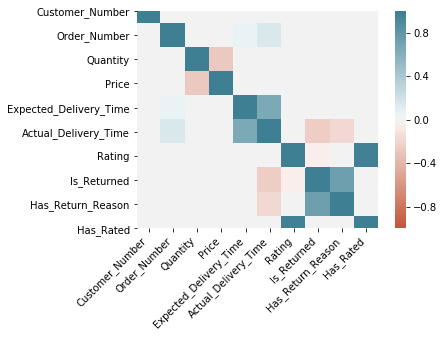

In [4]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Prediction
## Increase the number of customers between 30-40 years old by 50%

In [5]:
graph_data = data.copy()
graph_data = graph_data.groupby(['Order_Month'])['Price'].mean().reset_index(name='Price')

fig = px.bar(graph_data, x="Order_Month", y="Price")

x = pd.to_numeric(graph_data['Order_Month'].to_numpy(), downcast='integer').reshape((-1, 1))
y = graph_data['Price'].to_numpy()
model = LinearRegression().fit(x, y)

fig.add_trace(go.Scatter(x=graph_data['Order_Month'], y=model.predict(x),
                    mode='lines',
                    name='Trend line'))

print('Accuracy: %2.2f' % (model.score(x, y) * 100) + '%')

fig.update_layout(
    title_text="Average spending per product",
    xaxis_title="Date",
    yaxis_title="Price",
    font=dict(
        family="Roboto",
        size=14,
        color="#7f7f7f"
    )
)

fig.show()

Accuracy: 6.90%


In [6]:
graph_data = data[(data['Date_of_Birth'].dt.year >= 1979) & (data['Date_of_Birth'].dt.year <= 1989)].copy()
graph_data = graph_data.groupby(['Order_Month'])['Price'].sum().reset_index(name='Sales')

fig = px.bar(graph_data, x="Order_Month", y="Sales")

x = list(zip(graph_data['Order_Month'].dt.year.to_numpy(),graph_data['Order_Month'].dt.month.to_numpy()))
y = graph_data['Sales'].to_numpy()

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)

model = LinearRegression().fit(x_poly, y)

linear_x = pd.to_numeric(graph_data['Order_Month'].to_numpy(), downcast='integer').reshape((-1, 1))
linear_model = LinearRegression().fit(linear_x, y)

fig.add_trace(go.Scatter(x=graph_data['Order_Month'], y=model.predict(x_poly),
                    mode='lines',
                    name='Polynomial prediction'))

fig.add_trace(go.Scatter(x=graph_data['Order_Month'], y=linear_model.predict(linear_x),
                    mode='lines',
                    name='Linear prediction'))

print('Accuracy: %2.2f' % (model.score(x_poly, y) * 100) + '%')

fig.update_layout(
    title_text="Sales for age 30 to 40",
    xaxis_title="Date",
    yaxis_title="Sales",
    font=dict(
        family="Roboto",
        size=14,
        color="#7f7f7f"
    )
)

fig.show()

Accuracy: 55.03%


## Decrease the number of returned products returned by 20%

In [7]:
graph_data = data[data['Has_Return_Reason'] == True].copy()

fig = go.Figure()

def predictReturnReasonQuantity(type):
    model_data = graph_data[graph_data['Reason_of_Return'] == type]
    model_data = model_data.groupby(['Order_Month']).size().reset_index(name='Quantity')
    x = pd.to_numeric(model_data['Order_Month'].to_numpy(), downcast='integer').reshape((-1, 1))
    y = model_data['Quantity'].to_numpy()
    model = LinearRegression().fit(x, y)
    fig.add_trace(go.Scatter(x=model_data['Order_Month'], y=model.predict(x),
                    mode='lines',
                    name=type))

for type in graph_data['Reason_of_Return'].unique():
    predictReturnReasonQuantity(type)

fig.update_layout(
    title_text="Reasons of return trend lines",
    xaxis_title="Date",
    yaxis_title="Quantity",
    width=1200,
    font=dict(
        family="Roboto",
        size=14,
        color="#7f7f7f"
    )
)

fig.show()

In [8]:
graph_data = data.copy()
graph_data = graph_data.groupby(['Order_Month', 'Is_Returned']).size().reset_index(name='Count')

def fill_percentage(row):
    if row['Is_Returned'] == False:
        return np.nan
    not_returned = graph_data[(graph_data['Order_Month'] == row['Order_Month']) & (graph_data['Is_Returned'] == False)].iloc[0]['Count']
    return (row['Count'] / (row['Count'] + not_returned)) * 100

graph_data['Percentage'] = graph_data.apply(
    lambda row:
        fill_percentage(row),
    axis = 1)
graph_data = graph_data[pd.notnull(graph_data['Percentage'])]

fig = px.bar(graph_data, x="Order_Month", y="Percentage")

x = pd.to_numeric(graph_data['Order_Month'].to_numpy(), downcast='integer').reshape((-1, 1))
y = graph_data['Percentage'].to_numpy()
model = LinearRegression().fit(x, y)

fig.add_trace(go.Scatter(x=graph_data['Order_Month'], y=model.predict(x),
                    mode='lines',
                    name='Trend line'))

print('Accuracy: %2.2f' % (model.score(x, y) * 100) + '%')

fig.update_layout(
    title_text="Percentage of orders returned each month",
    xaxis_title="Date",
    yaxis_title="Percentage",
    font=dict(
        family="Roboto",
        size=14,
        color="#7f7f7f"
    )
)

fig.show()

Accuracy: 41.05%
